In [18]:
import argparse
import time 
import numpy as np
import pandas as pd
import csv
from collections import defaultdict
from functools import reduce
import random 

import csv
import numpy as np
import matplotlib.pyplot as plt




In [50]:

def getFreqs(pathFile):
    nsamples = defaultdict(list)
    #Dict for store for each snp present in the population its frequencies
    MAF = defaultdict(dict)
    with open(pathFile, "r") as f:
        reader = csv.reader(f, delimiter="\t")
        #iterate throught each SNP in frequencies file
        for i, line in enumerate(reader):
            if i != 0:
                nsamples[line[0]].append(line[3])
                genotypes = line[4:]
                freqs = [[x.split(':')[0],float(x.split(':')[1])] for x in genotypes]
                MAF[line[0]][int(line[1])] = dict()
                for i in freqs:
                    if str(i[1]) == 'nan':
                        try:
                            del MAF[line[0]][int(line[1])]
                        except:
                            pass
                    else:
                        MAF[line[0]][int(line[1])][i[0]] = i[1]
    return MAF

class AlleleP:
    def __init__(self,allele, freqs, priorP=None):
        self.allele = allele
        self.freqs = [freq[self.allele] for freq in freqs]
        
        if priorP != None:
            self.priorP = priorP
        else:
            self.priorP = [1.0/len(freqs)] * len(freqs)
        self.P = self.getAlleleP()
        self.backgroundProbabilities = list()
        self.getBackgroundProbabilities()

        
    def getAlleleP(self):
        P = 0
        for freq, priorP in zip(self.freqs, self.priorP):
            P += freq*priorP    
        return P
    
    def getGroupPgivenAllele(self, freq, priorP):
        try:
            P = freq*priorP/self.P
        except ZeroDivisionError:
            P = 0
        return P
    def getBackgroundProbabilities(self):
        for freq, priorP in zip(self.freqs, self.priorP):
            Pbackground = self.getGroupPgivenAllele(freq, priorP)
            self.backgroundProbabilities.append(Pbackground)
        
        

def initializeBackgroundP(freqs):
    groups = len(freqs)
    probs = defaultdict(dict)
    #chromosomes
    print("Computing probabilities for common SNPs between populations...")
    for chrom in freqs[0].keys():
        #get intersection of snps for each chrom between populations
        snpList = [list(freqPop[chrom].keys()) for freqPop in freqs]
        commonSNPs = reduce(np.intersect1d,snpList)
        #sizes by pop 
        sizes = [len(freqPop[chrom].keys()) for freqPop in freqs]
        print("%s: %s common SNPs %s" %(chrom, sizes, len(commonSNPs)))
        #snps
        for snp in commonSNPs:            
            alleles = freqs[0][chrom][snp].keys()
            probs[chrom][snp] = dict()
            for allele in alleles:
                ifrqs = [x[chrom][snp] for x in freqs]
                if len(ifrqs) == groups:
                    probs[chrom][snp][allele] = AlleleP(allele, ifrqs)
                else:
                    print(chrom, snp)
                
    return probs




def getWindowBackgroundInformativeness(window, sample):
    score = 0 
    for i, row in window.iterrows():   
        allele = row[sample].split('/')[0]
        try:
            backgroundProbs = outP[row['CHROM']][row['POS']][allele].backgroundProbabilities
            for backgroundP in backgroundProbs[1:]:
                score += backgroundP
        except KeyError:
            print(row[['CHROM', 'POS']])
    print(window['POS'].min(), window['POS'].max(), window.shape[0],score)
        

    return score

def getWindowScores(window, sample):
    scores = list()
    unshared = 0
    for i, row in window.iterrows():
        allele = row[sample].split('/')[0]
        try:
            backgroundProbs = np.array(outP[row['CHROM']][row['POS']][allele].backgroundProbabilities)
            
            #if backgroundProbs == [0,0]:
                #print(sample, row['CHROM'],row['POS'], row['sample'])
            scores.append(backgroundProbs)
        except KeyError:
            #multiallelic snps caution
            print(row[['CHROM', 'POS']])
    
    backgroundScores = np.array(scores).sum(axis=0)
    return backgroundScores/backgroundScores.sum()


def sumMaximumSlidingWindow(df, step, threshold,sample):
    nSNP = df.shape[0]
    name = sample
    chrm = df.iloc[0].CHROM
    dfWindows = pd.DataFrame(columns=['CHROM','n','nSNP','p0','p1','Md_p','GENPOS','POS','pi', 'pf','pr1', 'pr2'])
    p0 = 0
    p1 = threshold 
    n = 0
    flag = False
    #print("%s: %s"%(chrm,nSNP))
    while  p1 < nSNP :
        p = 0
        while p <= threshold:
            print(p0, p1, p)
            if p1 < nSNP:
                wSampleAlleles =  df.iloc[p0:p1]
                try:
                    p = getWindowBackgroundInformativeness(wSampleAlleles, sample)
                
                except Exception  as e: 
                    #print(e)
                    pass
                p1 += step
            else:
                flag = True
                break
        pr1,pr2 = getWindowScores(wSampleAlleles, sample)
        md_p= (p0+ p1)/2.0
        avGenPos =  wSampleAlleles['GENPOS'].mean()
        avPos =  wSampleAlleles['POS'].mean()
        nsnp = wSampleAlleles.shape[0]
        dfWindows.loc[len(dfWindows)] =  [chrm, n,nsnp,p0,p1,md_p,avGenPos,avPos,wSampleAlleles['POS'].min(),wSampleAlleles['POS'].max(), pr1, pr2]
        p0 += step
        p1 = p0 + threshold
        n += 1 #id ventana
        if flag:
            break
        
    return dfWindows
    
def getData(targetSamples,samplesFile, vcfFile, genposFile):
    #get sample index befor read vcf for load just certain columns
    samples = pd.read_csv(samplesFile, header=None)
    samples.rename(columns={0:'Genotype'}, inplace = True)
    samples['indexPos'] = samples.index + 2
    samplesIndex = list(samples[samples['Genotype'].isin(targetSamples)].indexPos)
    fields = [0, 1]
    fields.extend(samplesIndex)
    df = pd.read_csv(vcfFile, usecols=fields, sep='\t', na_values=['./.'], index_col=False, header = None, comment='#')
    colnames = ['CHROM', 'POS']
    colnames.extend(targetSamples)
    df.columns = colnames
    genPos = pd.read_csv(genposFile)
    genPos.rename(columns = ({'Chromosome':'CHROM', 'Position_bp': 'POS', 'Predicted_cM':'GENPOS'}), inplace=True)
    #    genPos.columns = ['CHROM', 'POS', 'GENPOS']
    genPos['id'] = df.index
    df['id'] = df.index
    df = pd.merge(df, genPos[['GENPOS', 'id']], on='id')
    
    return df



def MaximumSlidingWindows(samples, df, outP, threshold, step):
    columns = samples
    itime = time.time()
    similarities = list()
    for chrom, chData in df.groupby('CHROM'):
        bychmom = pd.DataFrame()
        comparableDf = chData[chData.POS.isin(list(outP[chrom].keys()))]
        initialSize = comparableDf.shape[0]
        comparableDf = comparableDf.dropna()  
        print("%s Not Genotyped SNPs: %s of %s" % (chrom, (initialSize - comparableDf.shape[0]), initialSize))
        simChom = sumMaximumSlidingWindow(comparableDf,step,threshold,samples[0])
        similarities.append(simChom)
    print(time.time() - itime)
    return(pd.concat(similarities))


# Initialization of frequencies for each population

In [3]:
WD='./../..'
file='GCDT_plates_fix_Vulgaris_v2_Bi_Q40_Dp3_imiss83_NS99_MAF2_He2_annotated'

acutFrq = getFreqs('%s/data/custom_script/%s_pop_parents_acut.frq' % (WD, file))
vulFrq = getFreqs('%s/data/custom_script/%s_pop_parents_vul.frq' % (WD, file))
outP = initializeBackgroundP([vulFrq,acutFrq])


Computing probabilities for common SNPs between populations...
Chr01: [5707, 4963] common SNPs 4963
Chr02: [1618, 966] common SNPs 966
Chr03: [9404, 7225] common SNPs 7225
Chr04: [1712, 1139] common SNPs 1139
Chr05: [1814, 1279] common SNPs 1279
Chr06: [2673, 1708] common SNPs 1708
Chr07: [1833, 1299] common SNPs 1299
Chr08: [5019, 3380] common SNPs 3380
Chr09: [2003, 1624] common SNPs 1624
Chr10: [2975, 1919] common SNPs 1919
Chr11: [1935, 1247] common SNPs 1247


In [24]:
def prettyPrint(data):
    alleles = list(data.keys())
    freqs = [data[a].freqs for a in alleles]
    backgroundProbabilities = [data[a].backgroundProbabilities for a in alleles]
    marginal = [data[a].P for a in alleles]
    probs = pd.DataFrame()
    for n, allele in enumerate(alleles):
        probs['f '+allele] = freqs[n]
        probs['p '+allele+'| Pi'] = backgroundProbabilities[n]
    marginal.extend(['-','-'])
    probs.loc[-1] = marginal
    probs.index = ['Vulgaris', 'Acutifolius', 'P(Ai)']
    return probs

prettyPrint(outP['Chr01'][3737820])

,f G,p G| Pi,f A,p A| Pi
Vulgaris,1.0,1.0,0,0
Acutifolius,0.0,0.0,1,1
P(Ai),0.5,0.5,-,-


In [7]:
targetSamples = ['GCDT_101']
samplesFile = WD+'/data/custom_script/'+'samples.txt'
vcfFile = WD+'/data/custom_script/'+file+'_TGT.vcf'
genposFile = WD+'/data/custom_script/'+file+'_gen_pos.csv'

df = getData(targetSamples, samplesFile, vcfFile, genposFile)

In [11]:
maxW = MaximumSlidingWindows(targetSamples, df, outP, 2,5)

Chr01 Not Genotyped SNPs: 195 of 4980
Chr02 Not Genotyped SNPs: 50 of 967
Chr03 Not Genotyped SNPs: 148 of 7260
Chr04 Not Genotyped SNPs: 51 of 1146
Chr05 Not Genotyped SNPs: 56 of 1286
Chr06 Not Genotyped SNPs: 113 of 1714
Chr07 Not Genotyped SNPs: 58 of 1305
Chr08 Not Genotyped SNPs: 128 of 3390
Chr09 Not Genotyped SNPs: 40 of 1626
Chr10 Not Genotyped SNPs: 66 of 1926
Chr11 Not Genotyped SNPs: 58 of 1251
39.58799195289612


In [51]:
for chrom, chData in df.groupby('CHROM'):
    comparableDf = chData[chData.POS.isin(list(outP[chrom].keys()))]
    initialSize = comparableDf.shape[0]
    comparableDf = comparableDf.dropna()  
    print("%s Not Genotyped SNPs: %s of %s" % (chrom, (initialSize - comparableDf.shape[0]), initialSize))
    simChom = sumMaximumSlidingWindow(comparableDf,10,10,targetSamples[0])
    break

Chr01 Not Genotyped SNPs: 195 of 4980
0 10 0
62054 72832 10 1.0476190476190477
0 20 1.0476190476190477
62054 113934 20 2.2476188076190957
0 30 2.2476188076190957
62054 157472 30 2.580952140952429
0 40 2.580952140952429
CHROM     Chr01
POS      167280
Name: 60, dtype: object
62054 167280 40 3.4142854742857627
0 50 3.4142854742857627
CHROM     Chr01
POS      167280
Name: 60, dtype: object
62054 167691 50 4.525396585396874
0 60 4.525396585396874
CHROM     Chr01
POS      167280
Name: 60, dtype: object
62054 213497 60 4.858729918730207
0 70 4.858729918730207
CHROM     Chr01
POS      167280
Name: 60, dtype: object
62054 379288 70 5.19206325206354
0 80 5.19206325206354
CHROM     Chr01
POS      167280
Name: 60, dtype: object
62054 391948 80 5.19206325206354
0 90 5.19206325206354
CHROM     Chr01
POS      167280
Name: 60, dtype: object
62054 392675 90 5.19206325206354
0 100 5.19206325206354
CHROM     Chr01
POS      167280
Name: 60, dtype: object
62054 408026 100 5.19206325206354
0 110 5.19206325

In [49]:
getWindowBackgroundInformativeness(comparableDf.iloc[0:40],targetSamples[0])

KeyError: 'A'

In [52]:
acutFrq['Chr01'][167280]

{'T': 0.0, 'G': 1.0}

# Introgression detection

In [2]:
from hmmlearn import hmm
from sklearn.cluster import AgglomerativeClustering
import os


In [53]:
def maskerhmm(df):
    out = list()
    for i, sdf in df.groupby(['CHROM']):
        model = hmmClassify(sdf[['pr1', 'pr2']], 2,verbose=False)
        X = sdf[['pr1', 'pr2']].to_numpy()
        labels = model.predict(X)
        out.extend(list(labels))
    return out

def hmmClassify(df, num_components, iterations=1000, num_samples = 1000,verbose=False):
    model = hmm.GaussianHMM(n_components=2,covariance_type="full", params ='st',init_params ='st')
    #model.transmat_ = np.array([[0.99,0.01],[0.01,0.99]])
    model.means_ = np.array([[0.6,0.4],[0.4,0.6]])
    
    X = np.column_stack([df[['pr1', 'pr2']].to_numpy()])
    model.fit(X)
    if True:
        for i in range(model.n_components):
            print('Hidden State', i+1)
            print('Mean =', round(model.means_[i][0], 3))
            print('Variance =', round(np.diag(model.covars_[i])[0], 3))
            print('\n')
    #print(model.score(X))
    #return np.column_stack([domain, samples[:,0]])
    return model
def PlotIntrgression(maxW, flag, sample):

    fig = make_subplots(rows=11, cols=1,subplot_titles=(["CHROM %s" %x for x in range(1,12)]), shared_xaxes=True, shared_yaxes=False)
    chrom = 1
    for n,sdf in maxW.groupby('CHROM'):    
        fig.append_trace(go.Scatter(
            x=sdf['GENPOS'],
            y=sdf['pr1'],
            name = 'Vulgaris',
            mode='lines',
            line = dict(color= "blue")
        ), row=chrom, col=1, )

        fig.append_trace(go.Scatter(
            x=sdf['GENPOS'],
            y=sdf['pr2'],
            name = 'Acutifolius',
            mode='lines',
            line = dict(color = "red")
        ), row=chrom, col=1, )
        if flag:
            fig.add_trace(go.Scatter(x=sdf['GENPOS'], y=[1]*sdf.shape[0],
                    mode='markers',
                    name='lines', marker=dict(
                            size=4,
                            color=sdf['mask'],
                            colorscale='Viridis', # one of plotly colorscales,
                            opacity=0.5
                            )), row=chrom, col=1,)

        #Introgression Mask
        chrom += 1

    fig.update_layout(height=2000, width=1000,
                      title_text="",
                      showlegend=False,
                         yaxis=dict( zeroline=True))
    #fig.write_html('./%s.html'%sample)
    fig.show()
    
def getIntrogressionSummary(maxW, sample):
    maxW.loc[maxW[maxW['pr2']>0.7].index,'mask'] = 1
    maxW.loc[maxW[maxW['pr2']<0.7].index,'mask'] = 0
    #x = maskerhmm(maxW)
    #maxW['mask'] = x
    data = maxW[maxW['mask']!=0].copy()
    introgressions = pd.DataFrame(columns=['CHROM','pi', 'pf', 'lp', 'gpi', 'gpf', 'lgp', 'nSNP', 'label'])
    for background, sdf in data.groupby(['CHROM', 'mask']):
        clustering = AgglomerativeClustering(n_clusters=None, linkage='single',distance_threshold=5)
        X = sdf['GENPOS'].to_numpy().reshape(-1, 1)
        if X.shape != (1,1):
            out = clustering.fit(X)
            sdf['label'] = out.labels_

            for i, ssdf in sdf.groupby(['label']):
                chrom = ssdf['CHROM'].unique()
                pi = ssdf['pi'].min()
                pf = ssdf['pf'].max()
                lp = pf - pi
                gpi = ssdf['GENPOS'].min()
                gpf = ssdf['GENPOS'].max()
                lgp = gpf - gpi
                nSNP = (ssdf.shape[0]-1) * 10 + ssdf.iloc[-1]['nSNP']
                row = pd.Series({'CHROM':chrom[0],'pi':pi, 'pf':pf, 'lp':lp, 'gpi':gpi, 'gpf':gpf, 'lgp':lgp, 'nSNP':nSNP, 'label':background[1]} )
                introgressions = introgressions.append(row, ignore_index=True)
    introgressions['Genotype'] = sample
    PlotIntrgression(maxW, True,sample)
    return introgressions

In [50]:
WD='./../..'

introgressionDfs = list()
for file in os.listdir(WD+'/results/custom_script/outs/'):
    sampleName = file[6:-4]
    maxW = pd.read_csv(WD+'/results/custom_script/outs/%s' % file, sep='\t')
    try:
        introTable = getIntrogressionSummary(maxW,sampleName)
        introgressionDfs.append(introTable)
    except ValueError:
        print(sampleName)

In [51]:
introgressionSummary = pd.concat(introgressionDfs, axis=0)
introgressionSummary.to_csv(WD+'/results/custom_script/introgression_summary.csv', index=False)

In [42]:
file='GCDT_plates_fix_Vulgaris_v2_Bi_Q40_Dp3_imiss83_NS99_MAF2_He2_annotated'
genposFile = WD+'/data/custom_script/'+file+'_gen_pos.csv'
genPosDf = pd.read_csv(genposFile)
genPosDf.rename(columns = ({'Chromosome':'CHROM', 'Position_bp': 'POS', 'Predicted_cM':'GENPOS'}), inplace=True)
minV = genPosDf.groupby('CHROM').min()
maxV = genPosDf.groupby('CHROM').max()
cumMax = np.cumsum(maxV['POS'])

chromSettings = pd.concat([minV['POS'],maxV['POS']], axis=1)
chromSettings['cumMax'] =cumMax
chromSettings.columns = ['min', 'max', 'cumMax']

In [43]:
rtios = list(maxV['POS']/cumMax[-1])

In [44]:
df = pd.read_csv(WD+'/results/custom_script/introgression_summary.csv')
df = df.sort_values(['CHROM', 'Genotype'])
df.Genotype.unique()

array(['G40056', 'G40287', 'GCDT_002', 'GCDT_101', 'GCDT_109', 'GCDT_113',
       'GCDT_154', 'GCDT_160', 'GCDT_161', 'GCDT_162', 'GCDT_163',
       'GCDT_165', 'GCDT_166', 'GCDT_167', 'GCDT_168', 'GCDT_169',
       'GCDT_173', 'GCDT_174', 'GCDT_175', 'GCDT_178', 'GCDT_180',
       'GCDT_183', 'GCDT_193', 'GCDT_194', 'GCDT_198', 'GCDT_199',
       'GCDT_205', 'GCDT_207', 'GCDT_208', 'GCDT_209', 'GCDT_222',
       'GCDT_227', 'GCDT_235', 'GCDT_236', 'GCDT_243', 'GCDT_245',
       'GCDT_249', 'GCDT_257', 'GCDT_262', 'GCDT_268', 'GCDT_269',
       'GCDT_271', 'GCDT_273', 'GCDT_276', 'GCDT_282', 'GCDT_290',
       'GCDT_092', 'GCDT_102', 'GCDT_103', 'GCDT_118', 'GCDT_155',
       'GCDT_022', 'GCDT_025', 'GCDT_029', 'GCDT_048', 'GCDT_051',
       'GCDT_052', 'GCDT_055', 'GCDT_057', 'GCDT_058', 'GCDT_059',
       'GCDT_060', 'GCDT_061', 'GCDT_062', 'GCDT_063', 'GCDT_064',
       'GCDT_065', 'GCDT_072', 'GCDT_074', 'GCDT_075', 'GCDT_093',
       'GCDT_119', 'GCDT_127', 'GCDT_151', 'GCDT_164',

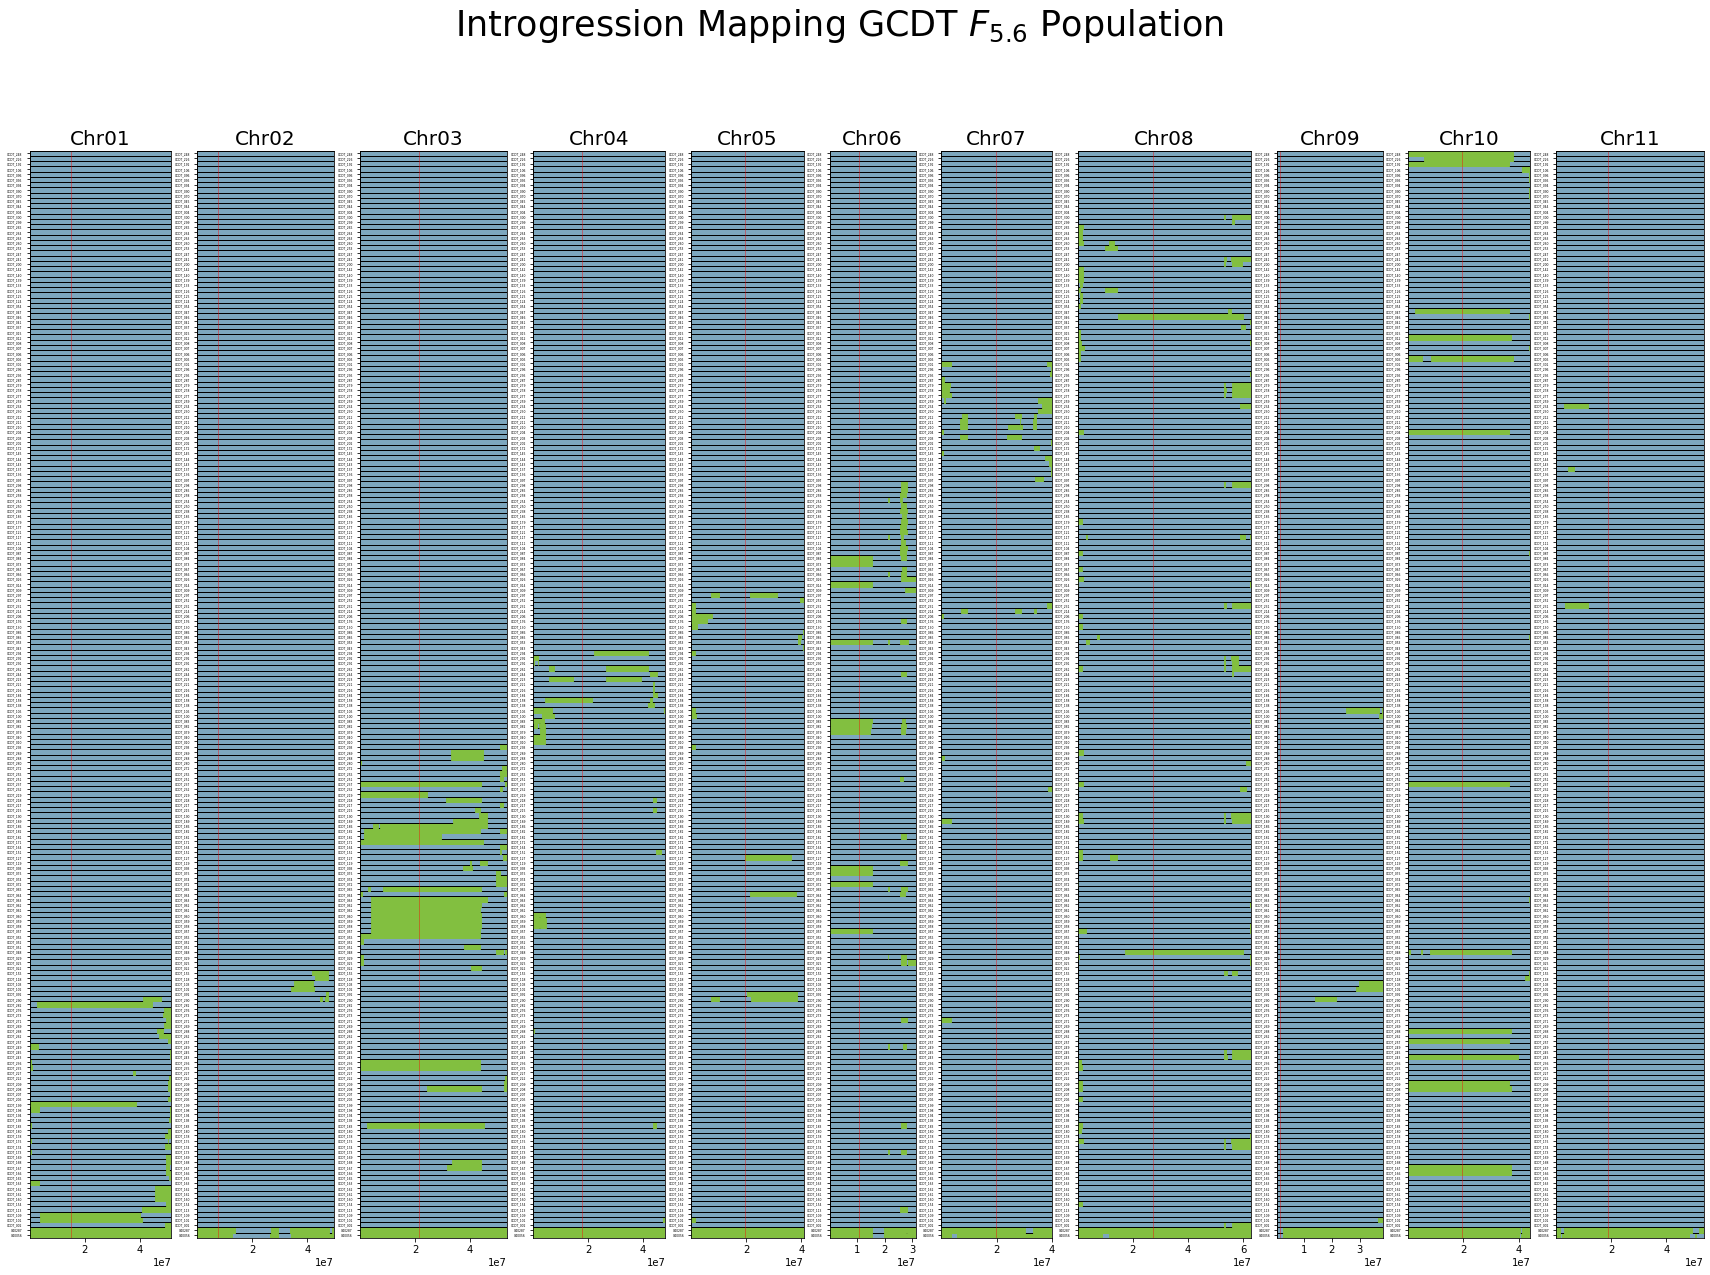

In [45]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

centromeres = {'Chr01':[12300000,17500000],
'Chr02':[5430000,9690000],
'Chr03':[16800000,25900000],
'Chr04':[7820000,27500000],
'Chr05':[10400000,28500000],
'Chr06':[10660000,10680000],
'Chr07':[19600000,19800000],
'Chr08':[23200000,31900000],
'Chr09':[1500000,1740000],
'Chr10':[15000000,24500000],
'Chr11':[16100000,21700000]}

ycoods = dict()
for n,i in enumerate(df.Genotype.unique()):
    ycoods[i] = n

colors = {
        'coccineus' : '#D36647',
        'acutifolius' : '#82BF40',
        'bg' : '#7DA7BE'
    }
nsamples = len(df.Genotype.unique())

fig, axs = plt.subplots(1,11, sharey=False, gridspec_kw={'width_ratios': rtios},figsize=(30,20))
count = 0
for chrom, row in chromSettings.iterrows():
    introCHROM = df[df['CHROM'] == chrom]
    
    centromereX = np.average(centromeres[chrom])
    line = mlines.Line2D([centromereX,centromereX],[0,nsamples] ,color='r', lw=1, alpha=0.4)
    axs[count].add_line(line)
    #set Chromosomes based on genetical position
    for i in ycoods.keys():
        xy = (row['min'], ycoods[i])
        width = row['max'] - row['min']
        r = mpatches.Rectangle(xy, width, 1, facecolor = colors['bg'], edgecolor='k')
        axs[count].add_patch(r)
        
        try:
            introGen = introCHROM[introCHROM['Genotype']==i]
            for idIntro, irow in introGen.iterrows():
                xy = (irow['pi'], ycoods[i])
                width =  irow['pf'] - irow['pi']
                r = mpatches.Rectangle(xy, width, 1, color = colors['acutifolius'])
                axs[count].add_patch(r)
            
        except:
            pass
    
    
    
    
    
    
    axs[count].set_xlim((row['min'],row['max']))
    axs[count].set_ylim((0,nsamples))
    axs[count].set_yticks(np.linspace(0.5,nsamples-0.5,nsamples))
    axs[count].set_yticklabels(df.Genotype.unique(), size=3)
    axs[count].set_title(chrom, size=20)
    count += 1
plt.suptitle('Introgression Mapping GCDT $F_{5.6}$ Population', size=35)
plt.savefig(WD+'/results/custom_script/introgression_summary.pdf')

# Introgression summary by sample

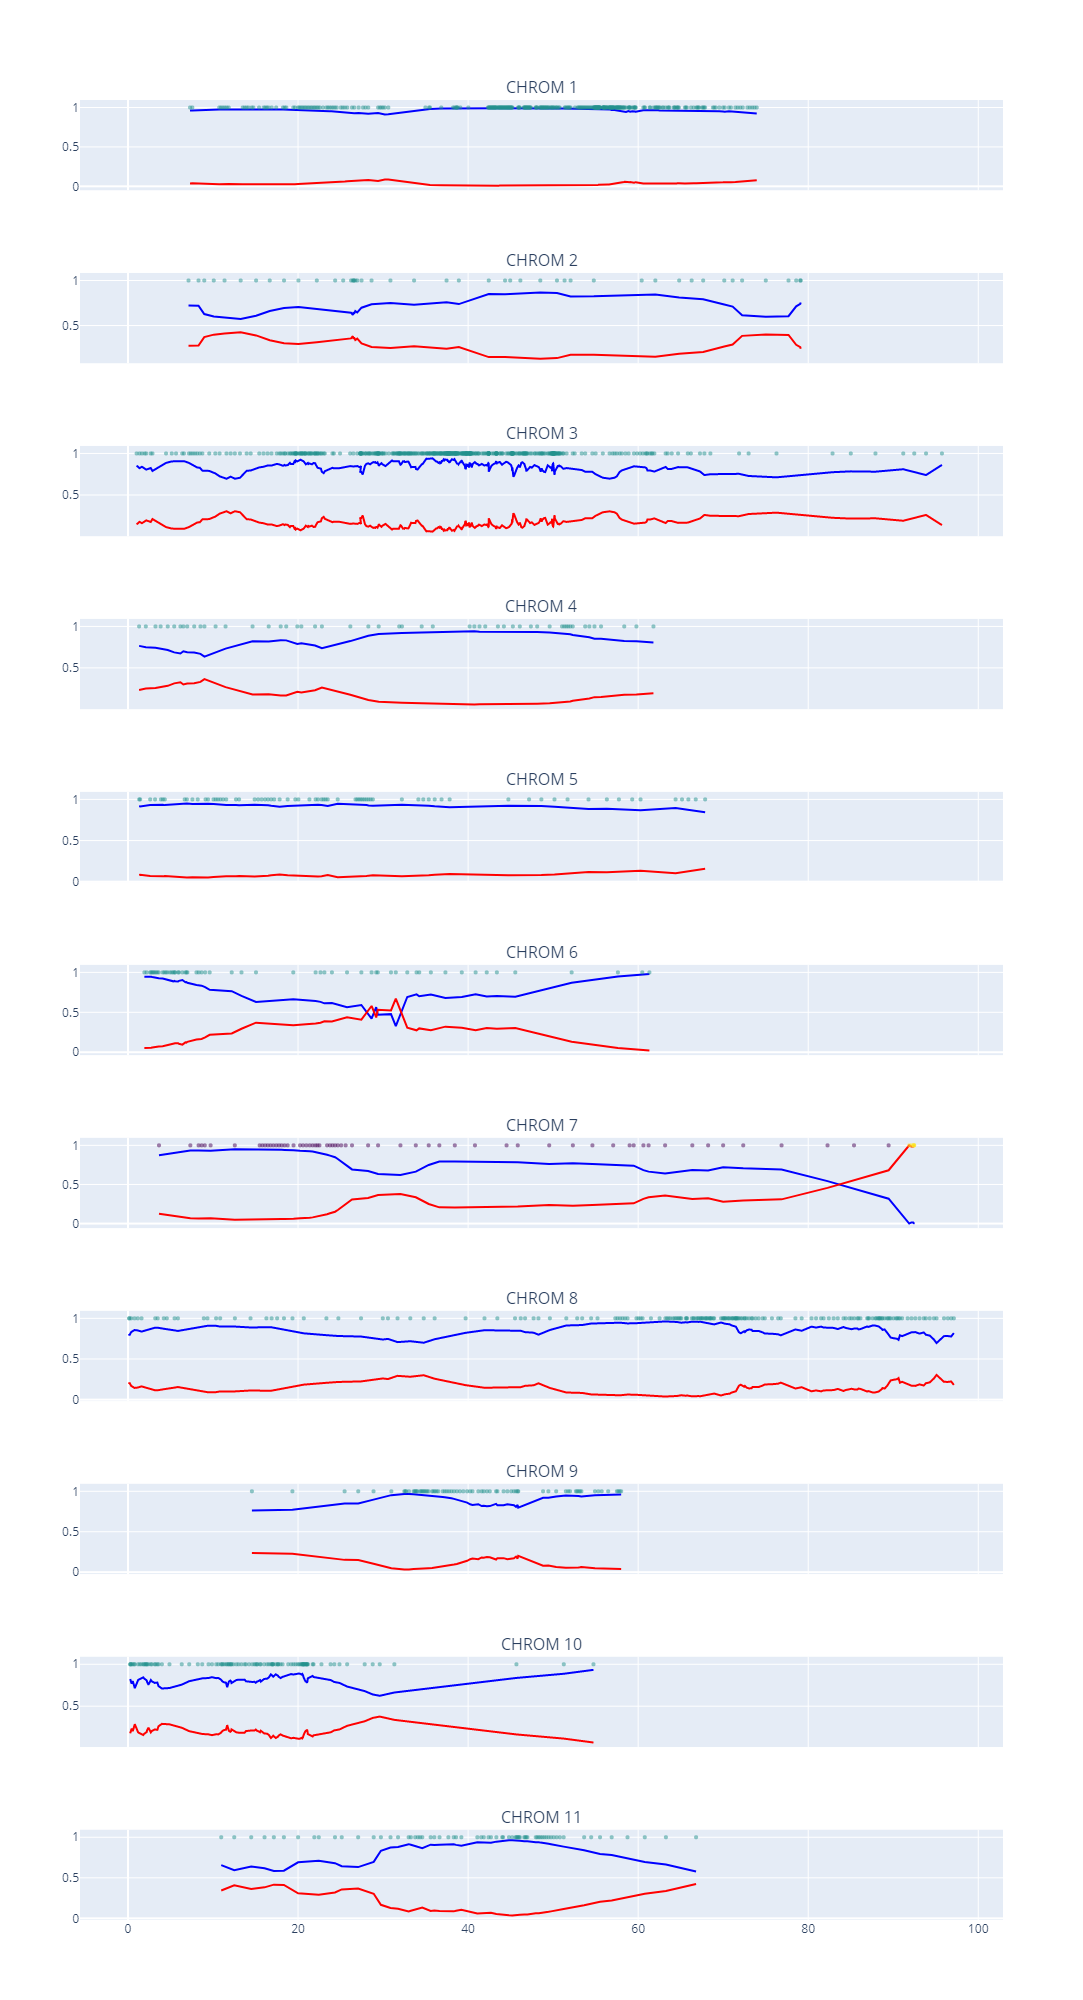

,CHROM,pi,pf,lp,gpi,gpf,lgp,nSNP,label,Genotype
0,Chr07,39740472,40011072,270600,91.876068,92.457974,0.581905,60,1.0,./results/custom_script/outs/Intro_GCDT_202


In [54]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import random 
import os
from plotly.subplots import make_subplots
import plotly.io as pio
WD='./../..'

file = WD+'/results/custom_script/outs/Intro_GCDT_202.csv'
sampleName = file[6:-4]
maxW = pd.read_csv(file, sep='\t')
getIntrogressionSummary(maxW,sampleName)

In [24]:
maxW.loc(maxW[maxW['pr2']>0.6])

TypeError: 'DataFrame' objects are mutable, thus they cannot be hashed

In [34]:
maxW.loc[maxW[~maxW['pr2']>0.6].index,'mask'] = 'acut'

TypeError: ufunc 'invert' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [35]:
maxW[~maxW['pr2']>0.6]

TypeError: ufunc 'invert' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''